In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_theme(style='whitegrid')
df = pd.read_csv('CollegePlacement.csv')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Overview of data
print('Basic Info')
df.info()

df.describe()

Basic Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   College_ID              10000 non-null  object 
 1   IQ                      10000 non-null  int64  
 2   Prev_Sem_Result         10000 non-null  float64
 3   CGPA                    10000 non-null  float64
 4   Academic_Performance    10000 non-null  int64  
 5   Internship_Experience   10000 non-null  object 
 6   Extra_Curricular_Score  10000 non-null  int64  
 7   Communication_Skills    10000 non-null  int64  
 8   Projects_Completed      10000 non-null  int64  
 9   Placement               10000 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 781.4+ KB


,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Extra_Curricular_Score,Communication_Skills,Projects_Completed
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,99.471800,7.535673,7.532379,5.546400,4.970900,5.561800,2.513400
std,15.053101,1.447519,1.470141,2.873477,3.160103,2.900866,1.715959
min,41.000000,5.000000,4.540000,1.000000,0.000000,1.000000,0.000000
25%,89.000000,6.290000,6.290000,3.000000,2.000000,3.000000,1.000000
50%,99.000000,7.560000,7.550000,6.000000,5.000000,6.000000,3.000000
75%,110.000000,8.790000,8.770000,8.000000,8.000000,8.000000,4.000000
max,158.000000,10.000000,10.460000,10.000000,10.000000,10.000000,5.000000


In [3]:
# Data cleaning
missing_values = df.isnull().sum()
print(missing_values)
# No missing values

College_ID                0
IQ                        0
Prev_Sem_Result           0
CGPA                      0
Academic_Performance      0
Internship_Experience     0
Extra_Curricular_Score    0
Communication_Skills      0
Projects_Completed        0
Placement                 0
dtype: int64


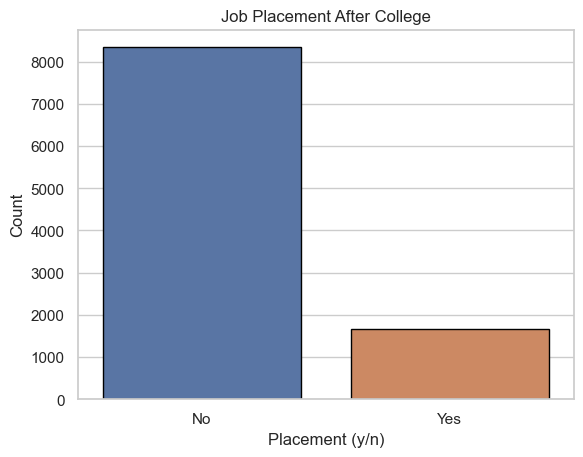

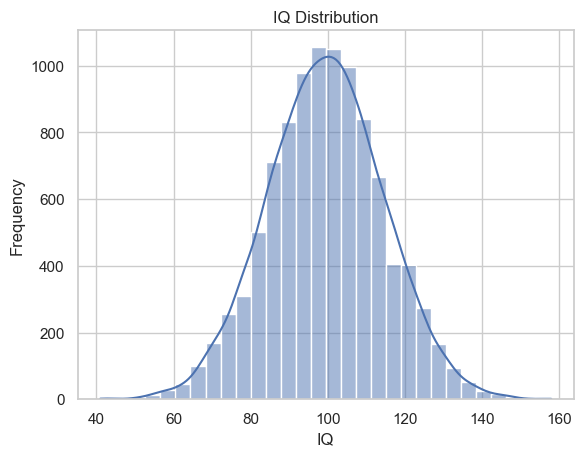

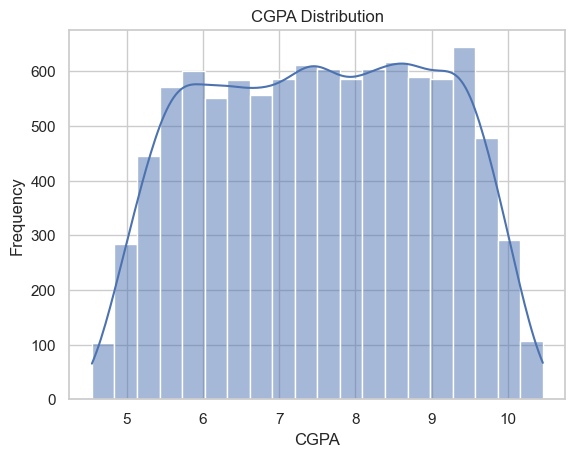

In [4]:
# Preliminary Analysis

# Histogram of Job Placements
plt.figure()
sns.countplot(x = 'Placement', data = df, palette='deep', edgecolor='black')
plt.title('Job Placement After College')
plt.xlabel('Placement (y/n)')
plt.ylabel('Count')
plt.show()

# IQ Distribution
plt.figure()
sns.histplot(df['IQ'], bins = 30, kde = True)
plt.title('IQ Distribution')
plt.xlabel('IQ')
plt.ylabel('Frequency')
plt.show()
# almost perfect bell shape!

# Cumulative GPA Distribution
plt.figure()
sns.histplot(df['CGPA'], bins = 20, kde = True)
plt.title('CGPA Distribution')
plt.xlabel('CGPA')
plt.ylabel('Frequency')
plt.show()



In [5]:
# Preparing for linear regression
# Transforming all data to numeric types
df["College_ID"] = df["College_ID"].map(lambda a: int(a[3:]))
df["Internship_Experience"] = df["Internship_Experience"].map({"Yes": 1, "No": 0})
df["Placement"] = df["Placement"].map({"Yes": 1, "No": 0})

df.head()

,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,30,107,6.61,6.28,8,0,8,8,4,0
1,61,97,5.52,5.37,8,0,7,8,0,0
2,36,109,5.36,5.83,9,0,3,1,1,0
3,55,122,5.47,5.75,6,1,1,6,1,0
4,4,96,7.91,7.69,7,0,8,10,2,0


# Logistic Regression (GLM based on Bernoulli's distribution)
1. Probability Distribution Model:

    $P(Y=y;p)=p^y (1-p)^{1-y}$

2. Likelihood:
    
    $L(\mathbf{p};\mathbf{y})=\prod_{i=1}^N P(Y=y_i;p_i)$

3. Log-likelihood:


   $\mathcal{L}(\mathbf{p};\mathbf{y})=\sum_{i=1}^N [y_i \ln(p_i) + (1-y_i)\ln(1-p_i)]$
4. Modeling step:

    Let $\ln(\frac{p}{1-p})=\mathbf{a}^T \mathbf{x}$; this constrains $p$ to be in $[0,1]$

5. Gradient of log-likelihood for gradient descent:
   
    $\nabla \mathcal{L}(\mathbf{a};X, \mathbf{y})=\sum_{i=1}^N [y_i \mathbf{x}_i - \frac{\mathbf{x}_i}{1+\exp(-\mathbf{a}^T \mathbf{x}_i)}]=\sum_{i=1}^N [\mathbf{x}_i(y_i - \sigma(\mathbf{a}^T \mathbf{x}_i))] = X^T (\mathbf{y} - \sigma(X \mathbf{a})$

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [7]:
def ll_grad(y, a, X):
    """
    Returns the gradient of the log-likelihood function
    """
    preds = sigmoid(X @ a)
    return X.T @ (y - preds)

In [8]:
def log_likelihood(X, y, a):
    """
    Returns the probability of the event (job placement) given the features and parameters
    """
    preds = sigmoid(X @ a)
    epsilon = 1e-15
    preds = np.clip(preds, epsilon, 1 - epsilon)
    return np.sum(y * np.log(preds) + (1 - y) * np.log(1 - preds))

In [9]:
# Gradient descent 
X_raw = df.drop('Placement', axis=1).values
y = df['Placement'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Bias term
X_train_final = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_final = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

# Gradient Ascent
learning_rate = 0.001
epochs = 100000
m, n = X_train_final.shape

a = np.zeros(n)
history = []

for i in range(epochs):
    # Calculate Gradient
    gradient = ll_grad(y_train, a, X_train_final)
    
    # Update Weights
    a += learning_rate * (gradient / m)  
    
    # Track Log-Likelihood
    ll = log_likelihood(X_train_final, y_train, a)
    history.append(ll)
    
    if i % (epochs / 10) == 0:
        print(f"Epoch {i}: Log-Likelihood {ll:.2f}")

Epoch 0: Log-Likelihood -5543.80
Epoch 10000: Log-Likelihood -2439.35
Epoch 20000: Log-Likelihood -2095.85
Epoch 30000: Log-Likelihood -1965.33
Epoch 40000: Log-Likelihood -1898.10
Epoch 50000: Log-Likelihood -1858.22
Epoch 60000: Log-Likelihood -1832.51
Epoch 70000: Log-Likelihood -1815.00
Epoch 80000: Log-Likelihood -1802.60
Epoch 90000: Log-Likelihood -1793.57


In [10]:
def predict(X, a, threshold=0.5):
    probs = sigmoid(X @ a)
    return (probs >= threshold).astype(int)


Final Weights (a): [-3.0775559   0.0481744   1.33508399  0.6743108   0.84508227 -0.02817524
  0.02107329 -0.02757698  1.54383066  0.97468241]


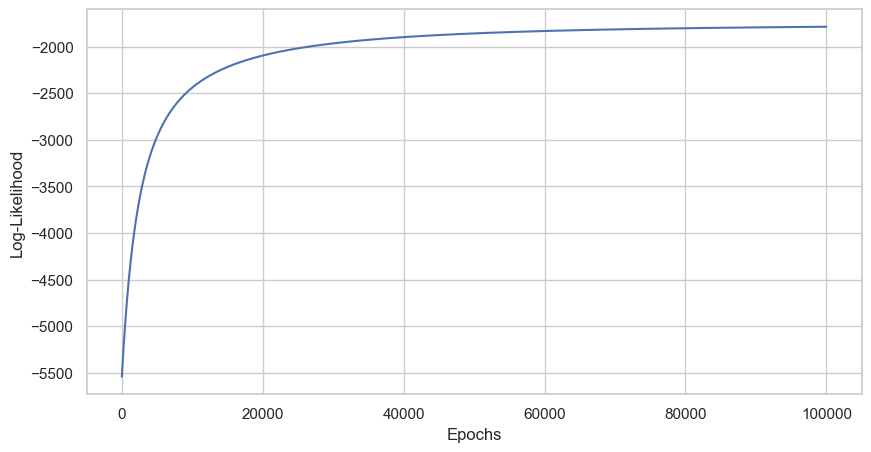

Test Set Accuracy: 90.40%


In [13]:
print(f"\nFinal Weights (a): {a}")
plt.figure(figsize=(10, 5))
plt.plot(history)
plt.xlabel("Epochs")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.show()

y_pred = predict(X_test_final, a)
acc = np.mean(y_pred == y_test)
print(f"Test Set Accuracy: {acc * 100:.2f}%")

In [27]:
history

[np.float64(-5543.803066082126),
 np.float64(-5542.4294815656895),
 np.float64(-5541.056690427055),
 np.float64(-5539.684692163201),
 np.float64(-5538.31348627128),
 np.float64(-5536.943072248624),
 np.float64(-5535.573449592739),
 np.float64(-5534.204617801311),
 np.float64(-5532.836576372202),
 np.float64(-5531.469324803451),
 np.float64(-5530.1028625932795),
 np.float64(-5528.737189240085),
 np.float64(-5527.372304242444),
 np.float64(-5526.008207099114),
 np.float64(-5524.64489730903),
 np.float64(-5523.282374371311),
 np.float64(-5521.920637785253),
 np.float64(-5520.559687050336),
 np.float64(-5519.199521666219),
 np.float64(-5517.840141132744),
 np.float64(-5516.481544949935),
 np.float64(-5515.123732617997),
 np.float64(-5513.7667036373205),
 np.float64(-5512.410457508477),
 np.float64(-5511.054993732222),
 np.float64(-5509.700311809494),
 np.float64(-5508.3464112414185),
 np.float64(-5506.993291529303),
 np.float64(-5505.64095217464),
 np.float64(-5504.289392679109),
 np.float